## Classifying and Natural Language Processing with Yelp Reviews Data
#### W207 Section 3, Group - <span style="color:orange"><strong>C</strong></span>olors
#### Summer, 2018
#### Team members:
- Chandra Sekar, chandra-sekar@ischool.berkeley.edu
- Guangyu (Gary) Pei, guangyu.pei@ischool.berkeley.edu
- Jooyeon (Irene) Seo, jooyeon@ischool.berkeley.edu
- Sijie (Anne) Yu, syu.anne@berkeley.edu

In [1]:
# General libraries.
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import sys
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# SK-learn libraries for learning.
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

# Config Jupyter session
%config IPCompleter.greedy=True

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

# Global configurations
np.set_printoptions(precision=4, suppress=True)

# Config system logs
import logging
logging.basicConfig(level=logging.INFO,
                   format='%(asctime)s %(levelname)s %(message)s')

# print versions
print("Python version used:", sys.version)
print("Numpy version used:", np.__version__)
print("sklearn version used:", sklearn.__version__)

Python version used: 3.5.2 (default, Nov 23 2017, 16:37:01) 
[GCC 5.4.0 20160609]
Numpy version used: 1.14.3
sklearn version used: 0.19.1


/home/pei/work/ref/pyenvs/mids/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/pei/work/ref/pyenvs/mids/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


#### Goals
Our project’s primary concept is to utilize Yelp data (from kaggle) to rate new business. That is, we are going to get Yelp user review data, use review texts to predict review is **positive** or **negative**. When people talk about a new business, we can capture their words, fit into the model, then predict its rating, sort of understand its quality and potential.

#### The Yelp Review Dataset
We write a shell [script](https://github.com/annesjyu/m207_summer_2018) to select $10,000$ reviews for training, testing and dev respectively, each set consisting in 50% negative and 50% positive reviews. We keep only review text and stars columns, then binarize stars into target label: 
- if starts >= $3.0$, review is *positive*
- otherwise, it's *negative*.

The following code will load the dataset and split it into $3$ sets:

In [3]:
with np.warnings.catch_warnings():
    # There are some bad data, we just dont want to see a lot of warning messages
    np.warnings.filterwarnings('ignore', r'Some errors were detected')
    data = np.genfromtxt('data.csv',dtype='str', delimiter='|', skip_header=1, 
                         usecols = (0,1), invalid_raise=False, loose=True)

    print ("Full data dim: ", data.shape)
    
    # Shuffle the data, each dataset will have roughly the same number of examples for each label.
    shuffle = np.random.permutation(np.arange(data.shape[0]))
    X, Y = data[shuffle, 0], data[shuffle, 1]    
    
    train_data, train_labels = X[0:12000], Y[:12000].astype(np.int)
    test_data, test_labels = X[12000:22000], Y[12000:22000].astype(np.int)
    dev_data, dev_labels = X[22000:-1], Y[22000:-1].astype(np.int)

    NUM_OF_TRAINING_DATA = len(train_data)
    NUM_OF_TESTING_DATA = len(test_data)
    NUM_OF_DEV_DATA = len(dev_data)

    print ('train data size: ', NUM_OF_TRAINING_DATA)
    print ('test data size: ', NUM_OF_TESTING_DATA)
    print ('dev data size: ', NUM_OF_DEV_DATA)
    print ('_'*80)
    print ('Training examples:\n', train_data[0:2])
    print (train_labels[0:2])
    print ('_'*80)
    print ('Testing examples:\n', test_data[0:2])
    print (test_labels[0:2])
    print ('_'*80)
    print ('Dev examples:\n', dev_data[0:2])
    print (dev_labels[0:2])

Full data dim:  (29701, 2)
train data size:  12000
test data size:  10000
dev data size:  7700
________________________________________________________________________________
Training examples:
 ['Orange Blossom Beer is the best  However atmosphere and Service (Female Bartender/Server) were really bad... Go to Chevron get a growler  go home and Enjoy!!! '
 "Tried this place one time shortly after they opened.   I wasn't really impressed with their food. The place did look neat and clean and the staff was very friendly.  Although I wasn't impressed with my one visit based on the customer service I'll probably try it again at some point. "]
[0 1]
________________________________________________________________________________
Testing examples:
 ['Not worth going to. I ordered a ramen and the chicken was very dry and over done  the soup was way too salty and tasted very artificial as well. Definitely way better ramen shops in the gta. The chicken bao was absolutely horrible because  1. I

Analyze train, dev and test datasets to find out data distributions. Ideally we want to have 50% examples for either label.

In [104]:
print ('positive train data: ', len(np.where(train_labels==1)[0]), 
       ', negative train data: ', len(np.where(train_labels==0)[0]))
print ('positive test data: ', len(np.where(test_labels==1)[0]), 
       ', negative test data: ', len(np.where(test_labels==0)[0]))
print ('positive dev data: ', len(np.where(dev_labels==1)[0]), 
       ', negative dev data: ', len(np.where(dev_labels==0)[0]))

positive train data:  6011 , negative train data:  5989
positive test data:  4990 , negative test data:  5010
positive dev data:  3862 , negative dev data:  3838


In [11]:
def load_data(fnm = "data_restaurants_reviews_30_to_200_stars_1_5", seed = 1234,
              train_frac= 0.8, dev_size = 1000):
    data = pd.read_pickle(fnm)
    np.random.seed(seed)
    data = data.sample(frac=1).reset_index(drop=True)
    print ("Total data size:", data.shape[0])
    traing_size = int(np.floor(data.shape[0]*train_frac))
    test_size = int(np.floor(data.shape[0]*(1.0-train_frac))) - dev_size
    train_data, train_labels = data.X[0:traing_size], data.Y[0:traing_size]
    test_data, test_labels = data.X[traing_size:(traing_size+test_size)], data.Y[traing_size:(traing_size+test_size)]
    dev_data, dev_labels = data.X[(traing_size+test_size):-1], data.Y[(traing_size+test_size):-1]
    return train_data, train_labels, test_data, test_labels, dev_data, dev_labels
    

train_data, train_labels, test_data, test_labels, dev_data, dev_labels = load_data()

print ('train data size: ', train_data.shape)
print ('test data size: ', test_data.shape)
print ('dev data size: ', dev_data.shape)

Total data size: 30000
train data size:  (24000,)
test data size:  (4999,)
dev data size:  (1000,)


#### Natural Language Processing

We will create doc-term matrix from data, so can fit all classifiers. There are a couple of steps of doing it.
...
...

##### Create a baseline using default CountVectorizer and NB

In [114]:
v = CountVectorizer(strip_accents='ascii', stop_words='english', min_df=0.001)
train_dtm = v.fit_transform(train_data)
print (train_dtm.shape)

bnb = BernoulliNB(alpha=0.01)
bnb.fit(train_dtm, train_labels)
predicted = bnb.predict(v.transform(dev_data))

print (classification_report(predicted, dev_labels))

terms = v.get_feature_names()
top100 = np.argsort(bnb.coef_[0])[-100:]
print ('top 100 terms:\n',[terms[int(w)] for w in top100])
print ('_'*80)
bottom100 = np.argsort(bnb.coef_[0])[:100]
print ('lest important 100 terms:\n',[terms[int(w)] for w in bottom100])
print ('_'*80)

(12000, 5303)
             precision    recall  f1-score   support

          0       0.76      0.87      0.81      3372
          1       0.89      0.79      0.84      4328

avg / total       0.83      0.83      0.83      7700

top 100 terms:
 ['kind', 'stars', 'different', 'favorite', 'probably', 'took', 'perfect', 'dinner', 'table', 'worth', 'hot', 'sweet', 'vegas', 'inside', 'home', 'bad', 'need', 'meal', 'drinks', 'salad', 'excellent', 'work', 'feel', 'quite', 'awesome', 'tried', 'happy', 'overall', 'cheese', 'long', 'location', 'thing', 'clean', 'looking', 'price', 'prices', 'wasn', 'big', 'lunch', 'sauce', 'night', 'super', 'eat', 'times', 'new', 'bar', 'lot', 'say', 'want', 'bit', 'fresh', 'day', 'll', 'wait', 'going', 'sure', 'small', 'experience', 'know', 'area', 'way', 'think', 'right', 'better', 'chicken', 'went', 'recommend', 'amazing', 'order', 'restaurant', 'didn', 'came', 'people', 'did', 'menu', 'make', 'ordered', 'pretty', 'delicious', 'come', 'got', 'staff', 'try', '

##### Logistic Regression Model

In this section, we will train Logistic Regression model.

Number of nonzero weights with l1 penalty is 1461.
Number of nonzero weights with l2 penalty is 3976.
Best F1 score with L2 regularization is 0.95.
The best F1 score is achieved by using the vocabulary size 3329 determined by L1 regularization with C parameter 8.85867


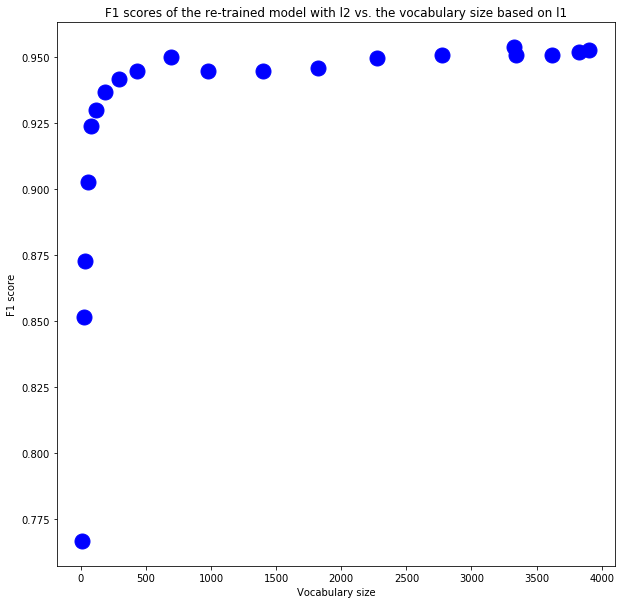

In [12]:
def yelp_review_logistic_regression_model(train_data = train_data,
                                          train_labels = train_labels,
                                          test_data = dev_data,
                                          test_labels = dev_labels,
                                          seed = 1234):
    # Keep this random seed so that this function is reproducible.
    np.random.seed(seed)
    count_vectorizer = CountVectorizer(strip_accents='ascii', stop_words='english', min_df=0.001)
    dtm_train = count_vectorizer.fit_transform(train_data)
    # compare the number of nonzero weights from l1 and l2
    logistic_l1 = LogisticRegression(penalty="l1")
    logistic_l1.fit(dtm_train, train_labels)
    # Method 1 using np.nonzero
    print("Number of nonzero weights with l1 penalty is {:d}.".format(len(set((np.nonzero(logistic_l1.coef_))[1]))))
    logistic_l2 = LogisticRegression(penalty="l2")
    logistic_l2.fit(dtm_train, train_labels)
    print("Number of nonzero weights with l2 penalty is {:d}.".format(len(set((np.nonzero(logistic_l2.coef_))[1]))))
    
    # vary C parameters and plot the graph
    vocabsizes = []
    l1_cs = []
    f1_scores = []
    for i in np.logspace(-3, 2, num=20):
        logistic_l1 = LogisticRegression(penalty="l1", tol=0.01, C=i)
        logistic_l1.fit(dtm_train, train_labels)
        # features that have at least one non-zero weights under l1 penalty
        l1_nonzero_vocab = np.array(count_vectorizer.get_feature_names())[list(set((np.nonzero(logistic_l1.coef_))[1]))]
        vocabsizes.append(len(l1_nonzero_vocab))
        l1_cs.append(i)
        # using vocabulary based on non-zero weights from l1 penalty logistic regression results
        vectorizer_with_reduced_vocab = CountVectorizer(vocabulary=l1_nonzero_vocab)
        dtm_with_reduced_vocab = vectorizer_with_reduced_vocab.fit_transform(train_data)
        dtm_test_with_reduced_vocab = vectorizer_with_reduced_vocab.transform(test_data)
        # fit logistic regression with penalty l2
        logistic_l2_retrain = LogisticRegression(penalty="l2")
        logistic_l2_retrain.fit(dtm_with_reduced_vocab, train_labels)
        f1_scores.append(metrics.f1_score(test_labels,
                                          logistic_l2_retrain.predict(dtm_test_with_reduced_vocab),
                                          average = 'macro'))
    
    # plot the results
    plt.figure(figsize=(10,10))
    plt.plot(vocabsizes, f1_scores, 'bo', markersize=15)
    plt.title('F1 scores of the re-trained model with l2 vs. the vocabulary size based on l1')
    plt.xlabel('Vocabulary size')
    plt.ylabel('F1 score')
    plt.rcParams["font.size"] = 12
    
    print("Best F1 score with L2 regularization is {:.2f}.\nThe best F1 score is achieved by using the vocabulary size {:d} determined by L1 regularization with C parameter {:.5f}"\
          .format(np.max(f1_scores),vocabsizes[np.argmax(f1_scores)],l1_cs[np.argmax(f1_scores)]))

yelp_review_logistic_regression_model()    